In [1]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time

Using TensorFlow backend.


In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

5000


In [3]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, mean_list[:6])
    if mean_list.mean() < 0:
        return False
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return False
    return True

In [ ]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

In [4]:
class myGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        return X, y

In [18]:
# tf.reset_default_graph()

save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# # Data files
# train_file = os.path.join(DATA_DIR, 'X_train.hkl')
# train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
# val_file = os.path.join(DATA_DIR, 'X_val.hkl')
# val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = None  # 100  number of sequences to use for validation

# Model parameters
image_size = 256
nt = 2  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
layer_loss_weights = np.array([1., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu', error_activation='elu',
                  output_mode='prediction', return_sequences=False)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
    w = tf.add(y_true, tf.constant(10.0))
    w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(1000.0))
    return loss

# errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
# errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
# errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
# final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer='adam')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 256, 256, 1)    0         
_________________________________________________________________
pred_net_3 (PredNet)         (None, 256, 256, 1)       711705    
Total params: 711,705
Trainable params: 711,705
Non-trainable params: 0
_________________________________________________________________


how to use tensorboard
```bash
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.1.115
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
```

In [20]:
lr_schedule = lambda epoch: 0.003 if epoch < 75 else 0.0003    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [21]:
train_generator = myGenerator(list_IDs=RAD_id_list[:5], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = myGenerator(list_IDs=RAD_id_list[-10:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=5000, validation_data=valid_generator, validation_steps=2 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

Epoch 1/5000
10/10 [==============================] - 2s 241ms/step - loss: 0.4222 - val_loss: 5.2953
Epoch 2/5000
10/10 [==============================] - 1s 118ms/step - loss: 0.4003 - val_loss: 5.5075
Epoch 3/5000
10/10 [==============================] - 1s 117ms/step - loss: 0.3960 - val_loss: 5.2772
Epoch 4/5000
10/10 [==============================] - 1s 118ms/step - loss: 0.3972 - val_loss: 5.2844
Epoch 5/5000
10/10 [==============================] - 1s 114ms/step - loss: 0.3892 - val_loss: 4.3500
Epoch 6/5000
10/10 [==============================] - 1s 115ms/step - loss: 0.3843 - val_loss: 4.3420
Epoch 7/5000
10/10 [==============================] - 1s 122ms/step - loss: 0.3816 - val_loss: 4.3421
Epoch 8/5000
10/10 [==============================] - 1s 114ms/step - loss: 0.3788 - val_loss: 4.4277
Epoch 9/5000
10/10 [==============================] - 1s 111ms/step - loss: 0.3750 - val_loss: 4.6593
Epoch 10/5000
10/10 [==============================] - 1s 122ms/step - loss: 0.378

10/10 [==============================] - 1s 120ms/step - loss: 0.2741 - val_loss: 4.5927
Epoch 81/5000
10/10 [==============================] - 1s 122ms/step - loss: 0.2737 - val_loss: 4.5923
Epoch 82/5000
10/10 [==============================] - 1s 121ms/step - loss: 0.2733 - val_loss: 4.5932
Epoch 83/5000
10/10 [==============================] - 1s 120ms/step - loss: 0.2729 - val_loss: 4.5972
Epoch 84/5000
10/10 [==============================] - 1s 125ms/step - loss: 0.2726 - val_loss: 4.5971
Epoch 85/5000
10/10 [==============================] - 1s 119ms/step - loss: 0.2722 - val_loss: 4.5985
Epoch 86/5000
10/10 [==============================] - 1s 115ms/step - loss: 0.2719 - val_loss: 4.5997
Epoch 87/5000
10/10 [==============================] - 1s 119ms/step - loss: 0.2716 - val_loss: 4.6000
Epoch 88/5000
10/10 [==============================] - 1s 122ms/step - loss: 0.2713 - val_loss: 4.6000
Epoch 89/5000
10/10 [==============================] - 1s 123ms/step - loss: 0.2709 - v

10/10 [==============================] - 1s 115ms/step - loss: 0.2589 - val_loss: 4.6753
Epoch 160/5000
10/10 [==============================] - 1s 121ms/step - loss: 0.2605 - val_loss: 4.6772
Epoch 161/5000
10/10 [==============================] - 1s 122ms/step - loss: 0.2588 - val_loss: 4.6759
Epoch 162/5000
10/10 [==============================] - 1s 117ms/step - loss: 0.2585 - val_loss: 4.6751
Epoch 163/5000
10/10 [==============================] - 1s 114ms/step - loss: 0.2581 - val_loss: 4.6717
Epoch 164/5000
10/10 [==============================] - 1s 113ms/step - loss: 0.2576 - val_loss: 4.6783
Epoch 165/5000
10/10 [==============================] - 1s 119ms/step - loss: 0.2573 - val_loss: 4.6786
Epoch 166/5000
10/10 [==============================] - 1s 123ms/step - loss: 0.2572 - val_loss: 4.6806
Epoch 167/5000
10/10 [==============================] - 1s 115ms/step - loss: 0.2570 - val_loss: 4.6830
Epoch 168/5000
10/10 [==============================] - 1s 116ms/step - loss: 0

10/10 [==============================] - 1s 119ms/step - loss: 0.2551 - val_loss: 4.6986
Epoch 238/5000
10/10 [==============================] - 1s 123ms/step - loss: 0.2545 - val_loss: 4.6867
Epoch 239/5000
10/10 [==============================] - 1s 118ms/step - loss: 0.2545 - val_loss: 4.6934
Epoch 240/5000
10/10 [==============================] - 1s 120ms/step - loss: 0.2540 - val_loss: 4.6957
Epoch 241/5000
10/10 [==============================] - 1s 121ms/step - loss: 0.2536 - val_loss: 4.6981
Epoch 242/5000
10/10 [==============================] - 1s 119ms/step - loss: 0.2535 - val_loss: 4.6944
Epoch 243/5000
10/10 [==============================] - 1s 118ms/step - loss: 0.2531 - val_loss: 4.6954
Epoch 244/5000
10/10 [==============================] - 1s 123ms/step - loss: 0.2530 - val_loss: 4.6989
Epoch 245/5000
10/10 [==============================] - 1s 115ms/step - loss: 0.2530 - val_loss: 4.6954
Epoch 246/5000
10/10 [==============================] - 1s 118ms/step - loss: 0

Process ForkPoolWorker-1101:
Process ForkPoolWorker-1099:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


Epoch 276/5000


  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/c

KeyboardInterrupt: 

In [14]:
train_generator = myGenerator(list_IDs=RAD_id_list[:4500], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=5)
valid_generator = myGenerator(list_IDs=RAD_id_list[4500:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=5)
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=5000, validation_data=valid_generator, validation_steps=20 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

Epoch 1/5000
100/100 [==============================] - 46s 457ms/step - loss: 3.2636 - val_loss: 4.2016

Epoch 2/5000
100/100 [==============================] - 47s 467ms/step - loss: 3.4990 - val_loss: 4.1498
Epoch 3/5000
100/100 [==============================] - 46s 461ms/step - loss: 3.4817 - val_loss: 4.0558
Epoch 4/5000
100/100 [==============================] - 46s 460ms/step - loss: 3.5039 - val_loss: 3.9355
Epoch 5/5000
100/100 [==============================] - 46s 457ms/step - loss: 3.3304 - val_loss: 4.0036
Epoch 6/5000
100/100 [==============================] - 46s 457ms/step - loss: 3.2437 - val_loss: 3.9398
Epoch 7/5000
 65/100 [==================>...........] - ETA: 12s - loss: 3.0933

Process ForkPoolWorker-231:
Process ForkPoolWorker-225:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
KeyboardInterrupt
  File 

KeyboardInterrupt: 

Process ForkPoolWorker-232:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [26]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][0]:
    x, y_ = data
    break
y = model.predict(x)

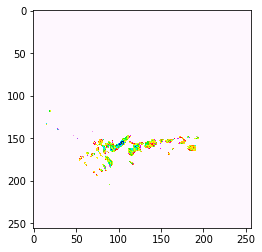

↓↓↓下面的是真实值，上面的是上一张↑↑↑


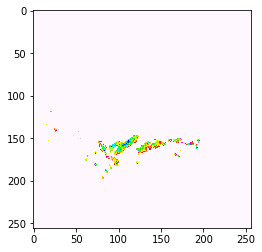

↓↓↓下面的是模型的输出，上面的是真实值↑↑↑


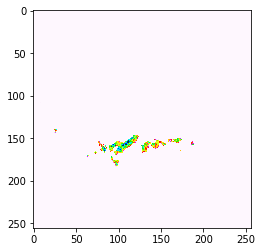

In [27]:
plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
model.()

In [ ]:
RAD_id = RAD_id_list[3]
x_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, nt, image_size, image_size, 1))
y_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 10)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, nt, image_size, image_size, 1))

In [ ]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [ ]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

In [ ]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

In [ ]:
%lsmagic

In [ ]:
%quickref